# Vehicle Detection and Tracking
---
> Daniel Stang
    

## Extract Features From Image

### Histogram of Gradient

In [4]:
# Import
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score

print('Import successful.')

Import successful.


In [38]:
# Histogram of Oriented Gradients
def hog_features(img, orientbin=9, cellpix=8, cellb=2, visual=False, vector=True):
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if visual == True:
        features, visual_image = hog(grayimg, orientations=orientbin,
                                     pixels_per_cell=(cellpix, cellpix),
                                     cells_per_block=(cellb, cellb),
                                     transform_sqrt=True,
                                     visualise=visual, feature_vector=vector)
        return features, visual_image
    else:
        features = hog(grayimg, orientations=orientbin,
                       pixels_per_cell=(cellpix, cellpix),
                       cells_per_block=(cellb, cellb),
                       transform_sqrt=True,
                       visualise=visual, feature_vector=vector)
        return features
        
    

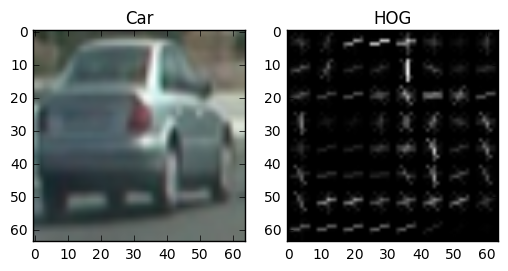

[ 0.03851183  0.00209297  0.0124189  ...,  0.00223787  0.00217299
  0.00244075]
1764


In [6]:
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')



orientbin = 9
cellpix = 8
cellb = 2

features, visual_image = hog_features(img, orientbin, cellpix, cellb, True)

fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Car')
plt.subplot(122)
plt.imshow(visual_image, cmap='gray')
plt.title('HOG')
plt.show()

print(features)
print(len(features))

## Train Classifier

### Label Data


In [7]:
imagename = sorted(glob.glob('img/non-vehicles/Extras/*.png'))
imagename2 = sorted(glob.glob('img/non-vehicles/GTI/*.png'))
imagename = imagename + imagename2
notcarlen = len(imagename)
print(notcarlen)
foldername = sorted(glob.glob('img/vehicles/*'))
for fold in foldername:
    imagename2 = sorted(glob.glob(fold + '/*.png'))
    imagename = imagename + imagename2

print(imagename[notcarlen-1])
print(imagename[notcarlen])
print(len(imagename))


9666
img/non-vehicles/GTI/image999.png
img/vehicles/GTI_Far/image0000.png
18458


In [8]:
# Load all images and extract features.
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')
testfeat = hog_features(img, orientbin, cellpix, cellb, False)

xdata = np.zeros((18458,len(testfeat))).astype('float32')
i=0
for imgn in tqdm(imagename):
    imgd = mpimg.imread(imgn)
    xdata[i] = hog_features(imgd, orientbin, cellpix, cellb, False)
    i = i + 1

    

100%|██████████| 18458/18458 [00:25<00:00, 715.34it/s]


In [9]:
# Ensure that non vehicles labeled with 0 and vehicles labeled with 1.
y = np.zeros(18458).astype(int)
y[9666:] = 1

print(str(imagename[9665]) + ' ' + str(y[9665]))
print(str(imagename[9666]) + ' ' + str(y[9666]))
print(str(imagename[1337]) + ' ' + str(y[1337]))
print(str(imagename[13337]) + ' ' + str(y[13337]))

img/non-vehicles/GTI/image999.png 0
img/vehicles/GTI_Far/image0000.png 1
img/non-vehicles/Extras/extra2201.png 0
img/vehicles/KITTI_extracted/1760.png 1


In [10]:
x_train, x_test, y_train, y_test = train_test_split(xdata, y, test_size=0.2, random_state=1337)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

14766
14766
3692
3692


### SVC

In [11]:
linsvc = svm.LinearSVC(loss='squared_hinge',tol=1e-4, max_iter=3000)
t = time.time()
linsvc.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', linsvc.score(x_train, y_train))
print('Test Accuracy', linsvc.score(x_test, y_test))

Training time: 3.2903072834014893 seconds
Train Accuracy 0.976770960314
Test Accuracy 0.962080173348


In [12]:
# svc = svm.SVC(kernel='linear')
# t = time.time()
# svc.fit(x_train, y_train)
# t2 = time.time()

# print('Training time:', t2-t, 'seconds')
# print('Train Accuracy', svc.score(x_train, y_train))
# print('Test Accuracy', svc.score(x_test, y_test))


# Stats using rbf kernel.
# 1.9 seconds to fit 922 samples.
# 121 seconds to fit 9229 samples.
# Takes waaaay to long when using rbf on so many samples
# and linear SVC seems to do just fine accuracy wise.

## Sliding Window Search


In [35]:
# Draw boxes on new image.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


# Return x and y coordinates for all computed window search positions.
def slide_window(img, y_start_stop=[350, None]):
    xy_window=[64, 64]
    xy_overlap=(0, 0)
    # If y start/stop positions not defined, set to image size.
    x_start_stop = [0, img.shape[1]]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Initialize a list to append window positions to.
    window_list = []
    
    yspan = (y_start_stop[1] - y_start_stop[0])
    
    ydist = yspan
    step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    endy = 0
    starty = y_start_stop[0]
    
    
    while (yspan > endy):
        print('Start - Y span:',yspan, '> Y end:', endy)
        
        step = np.int(xy_window[1] * (1 - xy_overlap[1]))
        ydist = ydist - step
        xy_window[1] = xy_window[1]*1.2
    
        # Compute the span of the region to be searched.
        xspan = (x_start_stop[1] - x_start_stop[0])
        # Compute the number of windows in x/y.
        nx_window = np.int(xspan/step - 1)
        
        endy = starty + step
        for xi in range(nx_window):
            startx = x_start_stop[0] + xi*step
            endx = startx + step
            starty = y_start_stop[0]
            window_list.append( ((startx, starty), (endx, endy)) )
        starty = endy
        print('End - Y span:',yspan, '> Y end:', endy, '\n')
    # Return the list of window positions.
    return window_list


# Crop window area of image 
def crop_resize(img, window):
    
    crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    
    resize = cv2.resize(crop, (64, 64))
    
    return resize


Start - Y span: 370 > Y end: 0
End - Y span: 370 > Y end: 414 



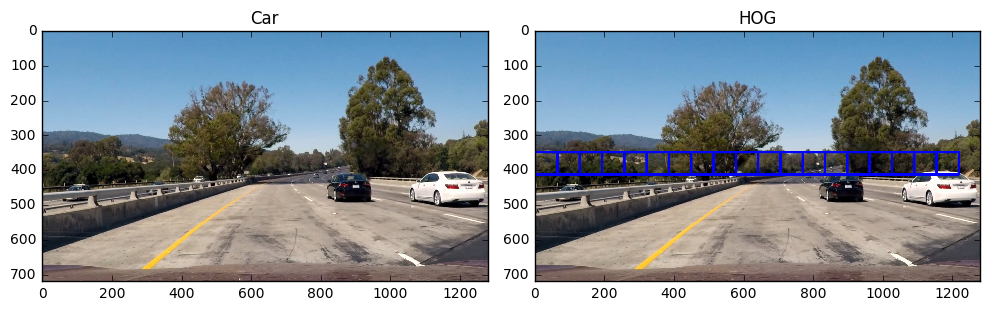

((0, 350), (64, 414))


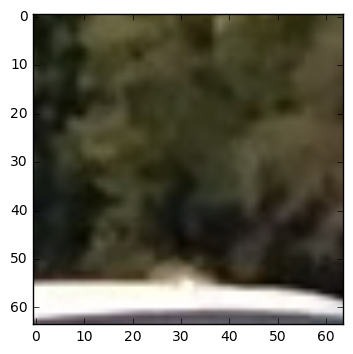

In [36]:
img = mpimg.imread('CarND-Vehicle-Detection/test_images/test1.jpg')

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.title('Car')

windows = slide_window(img)
imgbox = draw_boxes(img, windows)

plt.subplot(122)
plt.imshow(imgbox)
plt.title('HOG')
plt.tight_layout()
plt.show()

print(windows[0])
newimg = crop_resize(img, windows[-1])
plt.imshow(newimg)
plt.show()

In [45]:
linsvc.predict(hog_features(newimg)reshape(-1, 1)

error: /home/travis/miniconda/conda-bld/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7456: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor
